# Plot the Evaluation Rates
How many materials made it through each scale?

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import siegelslopes, linregress
from pathlib import Path
import pandas as pd
import numpy as np
import json

## Load the results
Get the results from the biggest scale, show how we compute the generation rate

In [2]:
path = Path('../prod-runs/450-nodes/')

### Generated Ligands
Start with the number of generated. We measure the number produced per batch using the "done" time as the time processing has completed

In [3]:
def load_generation(path: Path) -> pd.DataFrame:
    """Get the number of ligands produced a function of time

    Args:
        path: Path to the run directory
    Returns:
        Report of the number of ligands generated at each time point
    """

    # Get the number of ligands per task
    ligand_per_task = json.loads((path / 'params.json').read_text())['gen_batch_size']

    # Count the "process_ligand" tasks
    output = []
    with open(path / 'generation-results.json') as fp:
        for line in fp:
            record = json.loads(line)
            if record['method'] == 'process_ligands' and record['success']:
                output.append({
                    'time': record['task_info']['process_done'],
                    'num_made': ligand_per_task,
                })
    
    # Collect results
    output = pd.DataFrame(output)
    output['time'] -= output['time'].min()
    output.sort_values('time', inplace=True)
    output['total'] = output['num_made'].cumsum()
    return output
generated = load_generation(path)

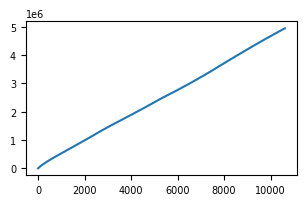

In [4]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

reg = linregress(generated['time'], generated['total'])
ax.step(generated['time'], generated['total'])

In [5]:
linregress(generated['time'], generated['total'])

LinregressResult(slope=458.0928106378539, intercept=55723.98374828417, rvalue=0.9998554350213728, pvalue=0.0, stderr=0.03962733250517207, intercept_stderr=242.90174962525995)

The result is very linear, so we can use standard linear regression

### Assembled MOFs
Use the results of the assembly tasks

In [6]:
def load_assembly(path: Path) -> pd.DataFrame:
    """Get the number of MOFs produced a function of time

    Args:
        path: Path to the run directory
    Returns:
        Report of the number of ligands generated at each time point
    """

    # Count the "process_ligand" tasks
    output = []
    with open(path / 'assembly-results.json') as fp:
        for line in fp:
            record = json.loads(line)
            if record['success']:
                output.append({
                    'time': record['timestamp']['result_received'],
                    'num_made': record['task_info']['to_make'],
                })
    
    # Collect results
    output = pd.DataFrame(output)
    output['time'] -= output['time'].min()
    output.sort_values('time', inplace=True)
    output['total'] = output['num_made'].cumsum()
    return output
assembled = load_assembly(path)

In [7]:
res = linregress(assembled['time'], assembled['total'])

Text(0, 0.5, 'Count')

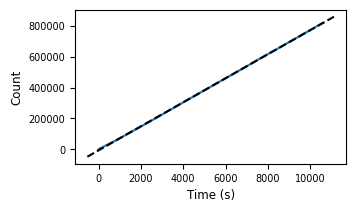

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.step(assembled['time'], assembled['total'])
ax.plot(ax.get_xlim(), np.multiply(res.slope, ax.get_xlim()) + res.intercept, 'k--')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Count')

## Stabilities Computed
Get the number of LAMMPS computations completed as a function of time

In [9]:
def load_lammps(path: Path) -> pd.DataFrame:
    """Get the number of MOFs through MD a function of time

    Args:
        path: Path to the run directory
    Returns:
        Report of the number of ligands generated at each time point
    """

    # Count the "process_ligand" tasks
    output = []
    with open(path / 'simulation-results.json') as fp:
        for line in fp:
            record = json.loads(line)
            if record['success'] and record['method'] == 'run_molecular_dynamics':
                output.append({
                    'time': record['timestamp']['result_received'],
                    'num_made': 1,
                })
    
    # Collect results
    output = pd.DataFrame(output)
    output['time'] -= output['time'].min()
    output.sort_values('time', inplace=True)
    output['total'] = output['num_made'].cumsum()
    return output
lammps = load_lammps(path)

In [10]:
res = linregress(lammps['time'], lammps['total'])

Text(0, 0.5, 'Count')

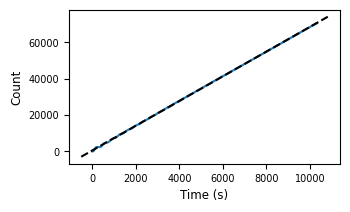

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.step(lammps['time'], lammps['total'])
ax.plot(ax.get_xlim(), np.multiply(res.slope, ax.get_xlim()) + res.intercept, 'k--')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Count')

## Gas Storage
From the RASPA finished

In [12]:
def load_raspa(path: Path) -> pd.DataFrame:
    """Get the number of MOFs through GCMC a function of time

    Args:
        path: Path to the run directory
    Returns:
        Report of the number of ligands generated at each time point
    """

    # Count the "process_ligand" tasks
    output = []
    with open(path / 'simulation-results.json') as fp:
        for line in fp:
            record = json.loads(line)
            if record['success'] and record['method'] == 'run_GCMC_single':
                output.append({
                    'time': record['timestamp']['result_received'],
                    'num_made': 1,
                })
    
    # Collect results
    output = pd.DataFrame(output)
    output['time'] -= output['time'].min()
    output.sort_values('time', inplace=True)
    output['total'] = output['num_made'].cumsum()
    return output
raspa = load_raspa(path)

In [13]:
res = siegelslopes(raspa['total'], raspa['time'])

Text(0, 0.5, 'Count')

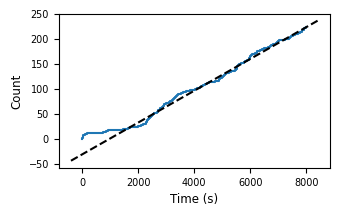

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.step(raspa['time'], raspa['total'])
ax.plot(ax.get_xlim(), np.multiply(res.slope, ax.get_xlim()) + res.intercept, 'k--')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Count')

## Summarize Over Scale
Plot these results as a function of scale

In [15]:
summary = []
for path in Path('../prod-runs/').glob('*-nodes'):
    nodes = int(path.name.split('-')[0])
    me = {'nodes': nodes}

    # Ones with linear regression
    for task, func in [
        ('DiffLinker', load_generation),
        ('Assembly', load_assembly),
        ('LAMMPS', load_lammps)
    ]:
        tasks = func(path)
        me[task + '-rate'] = linregress(tasks['time'], tasks['total']).slope * 3600

    # Ones with sparse regression
    for task, func in [
        ('CP2K+RASPA', load_raspa)
    ]:
        tasks = func(path)
        me[task + '-rate'] = siegelslopes(tasks['total'], tasks['time']).slope * 3600

    summary.append(me)
summary = pd.DataFrame(summary).sort_values('nodes')
summary

,nodes,DiffLinker-rate,Assembly-rate,LAMMPS-rate,CP2K+RASPA-rate
1,64,1.801904e+05,30028.931713,3557.010391,17.054113
2,256,8.922647e+05,150765.328746,14065.025027,62.023301
0,450,1.649134e+06,280278.829414,24425.866886,114.383164


Plot the scaling

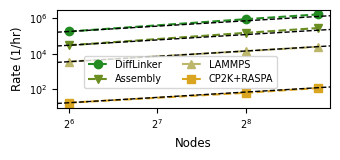

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 1.7))

markers = iter(['o', 'v', '^', 's'])
colors = iter(['forestgreen', 'olivedrab', 'darkkhaki', 'goldenrod'])
for c in summary.columns:
    if not c.endswith('-rate'):
        continue
    task = c.split('-')[0]

    ax.loglog(summary['nodes'], summary[c], '--', label=task, marker=next(markers), color=next(colors))
    ax.set_xlim(ax.get_xlim())

    # Plot the ideal scaling line
    lowest_rate = summary[c].iloc[0]
    ideal = lowest_rate / summary['nodes'].min()
    ax.plot(ax.get_xlim(), np.multiply(ideal, list(ax.get_xlim())), 'k--', lw=1)

ax.set_xscale('log', base=2)
ax.set_xlabel('Nodes')
ax.set_ylabel('Rate (1/hr)')
ax.legend(ncol=2, fontsize=7, loc=(0.1, 0.2))

fig.tight_layout()
fig.savefig('figures/task-rates-by-scale.png', dpi=320)
fig.savefig('figures/task-rates-by-scale.pdf', dpi=320)